<a href="https://colab.research.google.com/github/VincentCsNv/SymbioseManagement/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio laspy lazrs --quiet
#!pip install pdal --quiet #for VSCode
!pip install torch torchvision --quiet
!pip install scikit-learn --quiet
!pip install tqdm --quiet
!pip install torchsummary --quiet
!apt-get install -y pdal libpdal-dev --quiet


Reading package lists...
Building dependency tree...
Reading state information...
libpdal-dev is already the newest version (2.6.2+ds-1~jammy0).
pdal is already the newest version (2.6.2+ds-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
#For colab

! git clone https://github.com/VincentCsNv/SymbioseManagement.git
!cp -r SymbioseManagement/* ./ #extract files from the folder
!rm -rf SymbioseManagement #remove the folder


Cloning into 'SymbioseManagement'...
remote: Enumerating objects: 330, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 330 (delta 10), reused 14 (delta 5), pack-reused 309 (from 2)
Receiving objects: 100% (330/330), 131.70 MiB | 29.13 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import laspy
from pathlib import Path
import glob
import pandas as pd
import torch
import sklearn
from sklearn.metrics import classification_report, confusion_matrix,  f1_score, accuracy_score
import sys
from torch.utils.data import DataLoader
from torchsummary import summary


#Import personal lib
import lib.functions_utils as fu
import lib.models as models



from importlib import reload
reload(fu)
reload(models)

<module 'lib.models' from '/content/lib/models.py'>

In [4]:
DATA_dir = "data_light/"
repartition = { 'train': 0.8, 'val': 0.1, 'test': 0.1}
random_seed = 42

# I. Data :

## A. Collect data in dataframes:

In [5]:
#Getting data information in a dataframe
data_df = fu.extrating_data_to_df(DATA_dir, repartition = repartition, random_seed = random_seed, new_rep = True)
#fu.detailed_distribution(data_df[data_df["type"] == "imagery"]) #Visualization


Getting all the files .tiff and .laz path...
Number of files : 244


## B. DataLoader Creation :

In [6]:
batch_size = 2
input_type = 'lidar'  # 'imagery' or 'lidar'
transform = None  # Add any data augmentation or preprocessing transforms if needed

In [15]:
train_dataloader = fu.create_dataloader( df=data_df[data_df["dataset"]=="train"],  batch_size=batch_size, input_type=input_type, transform=transform)
val_dataloader = fu.create_dataloader( df=data_df[data_df["dataset"]=="val"],  batch_size=batch_size, input_type=input_type, transform=transform)
test_dataloader = fu.create_dataloader( df=data_df[data_df["dataset"]=="test"],  batch_size=batch_size, input_type=input_type, transform=transform)

#test
inputs, labels = next(iter(train_dataloader))
print(f'Input batch shape: {inputs.shape}')
print(f'Label batch shape: {labels.shape}')

Input batch shape: torch.Size([2, 3, 256])
Label batch shape: torch.Size([2])


# II. Model training :

In [8]:
#FOR Lidar
import shutil

if os.path.exists("/content/Pointnet_Pointnet2_pytorch"):
    shutil.rmtree("/content/Pointnet_Pointnet2_pytorch")
!git clone https://github.com/yanx27/Pointnet_Pointnet2_pytorch.git

project_root = "/content/Pointnet_Pointnet2_pytorch/models/"
sys.path.insert(0, str(project_root))

from pointnet2_cls_msg import get_model

Cloning into 'Pointnet_Pointnet2_pytorch'...
remote: Enumerating objects: 842, done.
remote: Total 842 (delta 0), reused 0 (delta 0), pack-reused 842 (from 1)
Receiving objects: 100% (842/842), 68.77 MiB | 23.68 MiB/s, done.
Resolving deltas: 100% (485/485), done.
Updating files: 100% (59/59), done.


In [12]:
if input_type == "imagery":
  model = models.convnet(nb_class=train_dataloader.dataset.num_classes)
  input_size = (4,128,128)
elif input_type =="lidar":
  model = get_model(num_class=3, normal_channel=False) #Getting PointNet model
  input_size = (3, 10028)

summary(model, input_size=input_size)  # Exclude batch size for input_size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 16, 512]             128
       BatchNorm2d-2          [-1, 32, 16, 512]              64
            Conv2d-3          [-1, 32, 16, 512]           1,056
       BatchNorm2d-4          [-1, 32, 16, 512]              64
            Conv2d-5          [-1, 64, 16, 512]           2,112
       BatchNorm2d-6          [-1, 64, 16, 512]             128
            Conv2d-7          [-1, 64, 32, 512]             256
       BatchNorm2d-8          [-1, 64, 32, 512]             128
            Conv2d-9          [-1, 64, 32, 512]           4,160
      BatchNorm2d-10          [-1, 64, 32, 512]             128
           Conv2d-11         [-1, 128, 32, 512]           8,320
      BatchNorm2d-12         [-1, 128, 32, 512]             256
           Conv2d-13         [-1, 64, 128, 512]             256
      BatchNorm2d-14         [-1, 64, 1

In [ ]:
reload(models)
results = models.train(model,train_dataloader,val_dataloader,
             epochs=3,
             max_lr=0.001,
             loss_func = torch.nn.CrossEntropyLoss(),
             optim = "Adam")

training in progress:  33%|███▎      | 1/3 [02:53<05:47, 173.85s/it]

Number of epochs: 1 | Validation loss : 1.4304145574569702  | Training loss : 1.2388310432434082  |   Training accuracy: 1.0 validation accuracy : 0.5833333134651184


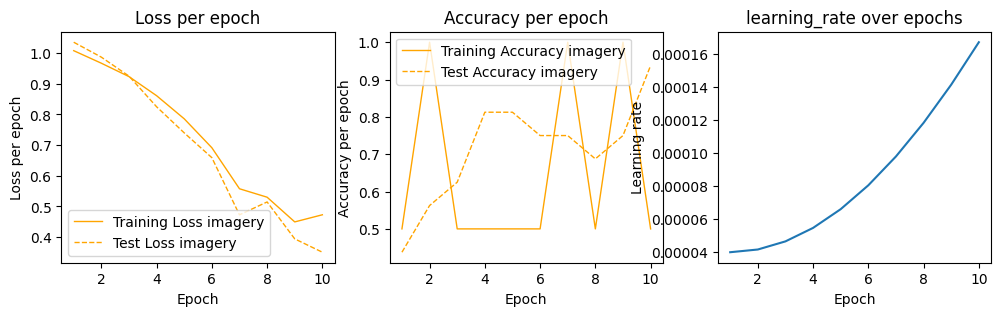

In [68]:
#Getting and plot metrics
plt.figure(figsize=(12,3))
epoch = 10
tr_acc,ts_acc,tr_loss,ts_loss,lr,epoch_count = fu.getting_metrics(results,epoch)
fu.plot_all_metrics(tr_acc,ts_acc,tr_loss,ts_loss,lr,epoch_count,label = input_type)


# III. Evaluate the model:

In [69]:

#Functions :
loss_func = torch.nn.CrossEntropyLoss()
from sklearn.metrics import classification_report, confusion_matrix,  f1_score, accuracy_score
import seaborn as sns

def eval_test(model_eval,testloader, loss_function, metric,all_info =False):
  model_eval.eval()
  batch_losses, batch_accs=[],[]
  all_predictions, all_labels = [], []  # Pour la matrice de confusion
  i=0

  for images,labels in testloader:
    predicted= model_eval(images)
    batch_losses.append(loss_func(predicted,labels))
    batch_accs.append(metric(predicted,labels))


    # Collecter pour matrice de confusion
    _, preds = torch.max(predicted, 1)  # Classes prédites
    all_predictions.extend(preds.cpu().numpy())#all_predictions.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy()) #   all_labels.extend(labels.cpu().numpy())

  if all_info:
    print(classification_report(all_labels, all_predictions))

  #print accuracy
  print(f"F1 Score: {f1_score(all_labels, all_predictions,average = "weighted")}")
  return all_predictions, all_labels

def plot_confusion_matrix(cm,SUPER_CLASSES,all_info = False,label=""):
  # Plot de la matrice de confusion
  class_names = SUPER_CLASSES
  #plt.figure(figsize=(4, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_names,yticklabels=class_names)
  plt.title(f'Matrice de Confusion {label}')
  plt.ylabel('Vraies labels')
  plt.xlabel('Prédictions')

def predict_img(img,model,mode = "A",GPU="false"):
  model.eval()
  img = img.unsqueeze(0)
  yb = model(img)
  _, pred = torch.max(yb, dim=1)
  pred = pred.item()
  return pred

def predict_and_show(img,label,model,mode = "A",GPU = "False"):
  pred = predict_img(img,model,mode=mode,GPU=GPU)
  #Getting Super Class name from ground truth and prediction
  img=img*0.5 +0.5 #Denormalize the img
  plt.imshow(img.permute(1, 2, 0)[:,:,:3])
  plt.title(f"gt: ")
  return pred

In [71]:
#PARAMETERS and CKP
MODEL_eval = "conv"
PATH_CKP = '/content/model_optim_Adam_best_epoch_weights.pth'

print("Evaluation of model")
model_eval = models.convnet(nb_class=train_dataloader.dataset.num_classes)
model_eval.load_state_dict(torch.load(PATH_CKP))
all_predictions, all_labels = eval_test(model_eval,test_dataloader,loss_func,models.accuracy)
cm_A =   confusion_matrix(all_labels, all_predictions)




Evaluation of model
F1 Score: 0.753968253968254


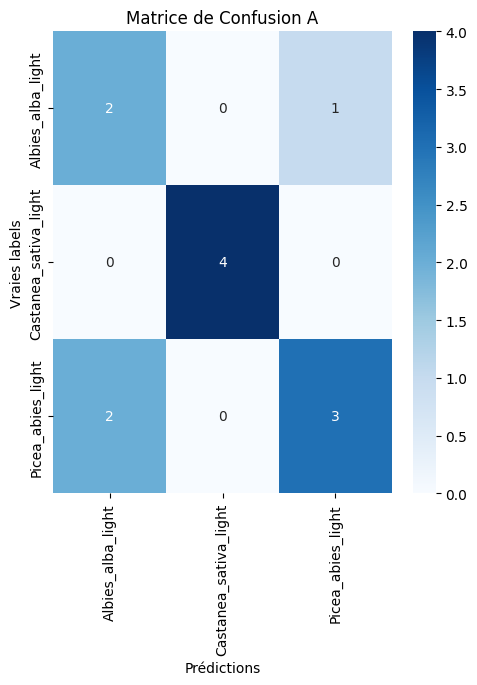

In [72]:
plt.figure(figsize=(12,6))
species = data_df["species"].unique()
#Option A
plt.subplot(1,2,1)
plot_confusion_matrix(cm_A,species,label="A")
